In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pycbc
import os, time, h5py
from IPython.display import display, clear_output
from pycbc.waveform import get_td_waveform

In [2]:
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
figsize=(10,8)

In [3]:
sample_rate = 2048#4096
duration = 6.
dt=1./sample_rate

f0 = 20.
f_low = 20.
f_high =  2048.
df = 1.
m1_min = 1.
m1_max = 99.
m2_min = m1_min
m2_max = m1_max
max_total_m = 100.
max_spin = 0.99

min_match = 0.97
filter_cutoff = 'SchwarzISCO'
psd_model = 'aLIGODesignSensitivityP1200087'

outfile='template_bank.xml'
template_file='templates'
signal_file='signal'
noise_file='noise'

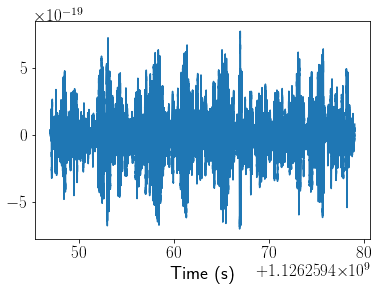

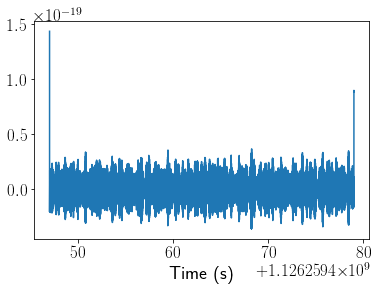

In [4]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW150914")
strain = merger.strain('H1')
plt.plot(strain.sample_times,strain)
plt.xlabel('Time (s)')
plt.show()
strain = resample_to_delta_t(highpass(strain, f_low), dt)
plt.plot(strain.sample_times,strain)
plt.xlabel('Time (s)')

plt.show()

In [5]:
print(strain.sample_times[int(len(strain.sample_times)/2)])

1126259463.0


In [23]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
#conditioned = strain.crop(5, 5)
conditioned = strain.crop(2, 2)
#noise = strain.crop(28, 0)
psd = conditioned.psd(1)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(sample_rate),
                                  low_frequency_cutoff=f_low)

#plt.figure(figsize=[10, 4])
#plt.plot(noise.sample_times, noise)
#plt.xlabel('Time (s)')
#plt.show()

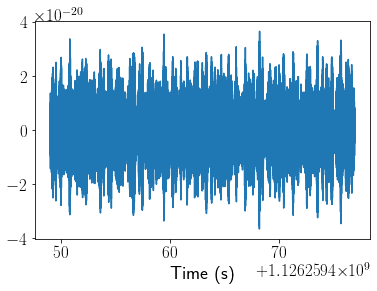

In [24]:
plt.plot(conditioned.sample_times,conditioned)
plt.xlabel('Time (s)')
plt.show()

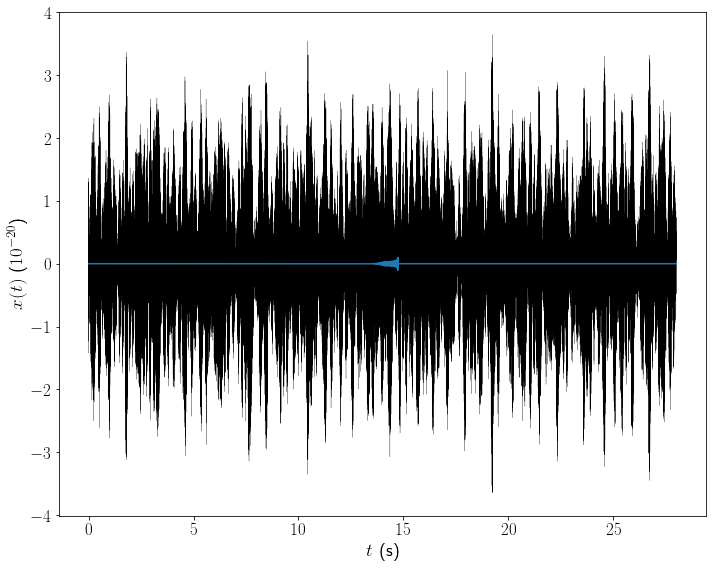

In [25]:
fig = plt.figure(figsize=figsize)

waveform = get_td_waveform(approximant="IMRPhenomPv3",
                            mass1=35.6, mass2=30.6,
                            spin1z=0., spin2z=0.,
                            delta_t=1./2048, f_lower=20)
waveform = waveform[0]
padlen = int((len(conditioned)-len(waveform))/2)
waveform = np.pad(waveform,(padlen,padlen))
waveform = (1.e-21*waveform/np.max(waveform))
plt.plot(np.arange(len(conditioned))/2048., conditioned/1.e-20, lw=.2, color='black')
plt.plot(np.arange(len(conditioned))/2048., waveform/1.e-20)
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$x(t)$ ($10^{-20}$)')
plt.savefig('plots/strain.png')
plt.tight_layout()
plt.show()

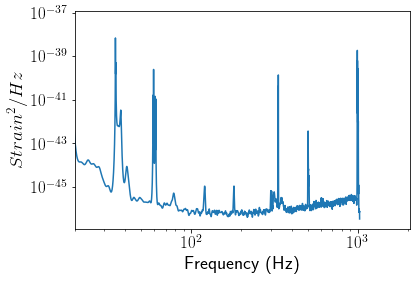

In [26]:
plt.loglog(psd.sample_frequencies, psd)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.xlim(f_low, f_high)
plt.show()

In [27]:
datafreq = np.fft.fftfreq(len(conditioned))*sample_rate
psd_ = np.interp(datafreq, np.array(psd.sample_frequencies), np.array(psd))
np.save('psd',psd_)

In [11]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import make_frequency_series
from pycbc.types import TimeSeries, FrequencySeries

templates = []
hps= []
hps_f= []

if True:
    
    M = int(2**(9))

    #N, M = initial_states.shape[0], initial_states.shape[1]
    bank_file = 'H1L1-BANK2HDF_SPLITBANK_BANK0_INJECTIONS-1134450017-1202400.hdf'
    full_bank = h5py.File(bank_file,'r')

    bank_size = full_bank['mass1'].size
    
    bank = {}
    bank['mass1'] = full_bank['mass1'][np.arange(bank_size)[::int(bank_size//M)]]    
    bank['mass2'] = full_bank['mass2'][np.arange(bank_size)[::int(bank_size//M)]]    
    bank['spin1z'] = full_bank['spin1z'][np.arange(bank_size)[::int(bank_size//M)]]    
    bank['spin2z'] = full_bank['spin2z'][np.arange(bank_size)[::int(bank_size//M)]]  
    bank['f_lower'] = full_bank['f_lower'][np.arange(bank_size)[::int(bank_size//M)]]
    
    templates = []

    for i in np.arange(bank_size)[::int(bank_size//M)]:
        print(float(full_bank['mass1'][i]),float(full_bank['mass2'][i]))
        hp, hc = get_td_waveform(approximant="IMRPhenomPv3",
                            mass1=float(full_bank['mass1'][i]),
                            mass2=float(full_bank['mass2'][i]),
                            spin1z=float(full_bank['spin1z'][i]),
                            spin2z=float(full_bank['spin2z'][i]),
                            delta_t=conditioned.delta_t,
                            f_lower=float(full_bank['f_lower'][i]))
            
        hp.resize(len(conditioned))
        template = hp.cyclic_time_shift(hp.start_time)
        #waveform[0].resize(len(conditioned))
        #waveform[0] = waveform[0].cyclic_time_shift(waveform[0].start_time)
        #hps.append(waveform[0])
        hps_f.append(np.array(make_frequency_series(TimeSeries(template,delta_t=dt))))
        #fhp = np.fft.fft(np.array(waveform[0]))
        #sq = np.abs((fhp * fhp.conjugate() / psd_).sum())
        #norm = 4. / np.sqrt(4. * np.abs(datafreq[1]-datafreq[0]) * sq)
        #templates.append((fhp/psd_)*norm)
    #templates = np.array(templates)
    #np.save(template_file,templates)
    print('Done!')

4.53513765335083 1.0307602882385254
81.96794128417969 2.744523525238037
8.021625518798828 5.025692462921143
3.193128824234009 1.4620200395584106
30.678110122680664 1.0099891424179077
17.147281646728516 1.0874663591384888
4.1642022132873535 1.0029922723770142
2.9239988327026367 1.225514531135559
7.376457214355469 1.758256196975708
34.367523193359375 1.2412476539611816
10.280062675476074 5.03410005569458
3.7983694076538086 1.0566295385360718
7.498873233795166 1.0752466917037964
9.27741813659668 1.0208258628845215
46.24656295776367 1.0245803594589233
18.651063919067383 1.0444101095199585
25.15205955505371 1.1606941223144531
22.14354133605957 1.7764549255371094
3.1234261989593506 2.319679021835327
16.217945098876953 1.2297724485397339
1.452284812927246 1.2012710571289062
20.419607162475586 1.08103346824646
5.159491062164307 1.971838355064392
30.977188110351562 1.164900541305542
279.46453857421875 3.359069585800171
3.8580594062805176 2.1313652992248535
19.839183807373047 1.1603202819824219


12.044639587402344 3.705148935317993
3.5156877040863037 1.200398325920105
16.64183807373047 1.013453722000122
5.2849650382995605 5.055084705352783
16.543333053588867 1.4286870956420898
15.554567337036133 1.0666567087173462
2.2090721130371094 1.0833592414855957
254.32212829589844 4.837086200714111
50.02915954589844 1.5317318439483643
16.27801513671875 1.558227300643921
3.4377593994140625 1.0451966524124146
9.427632331848145 5.987401008605957
17.50241470336914 1.0264309644699097
9.128179550170898 1.0269006490707397
59.85087966918945 1.1952120065689087
5.9964680671691895 3.0225260257720947
3.528578519821167 2.442237615585327
28.72704315185547 1.3939210176467896
2.2113699913024902 1.1065367460250854
4.888906002044678 1.0026707649230957
2.6347525119781494 1.1996530294418335
5.323332786560059 1.0046385526657104
44.857425689697266 1.030094861984253
12.01945686340332 1.1484109163284302
35.4437370300293 1.0864895582199097
40.887874603271484 1.0165143013000488
3.6189920902252197 1.03507280349731

10.731184005737305 1.119631290435791
66.79290008544922 1.8373252153396606
274.6152648925781 2.83837628364563
12.46565055847168 1.3871612548828125
75.49456787109375 1.8269628286361694
2.0743191242218018 1.0608551502227783
5.467089653015137 1.0739425420761108
85.47498321533203 1.0693507194519043
41.53419494628906 1.7665055990219116
49.617549896240234 1.2581123113632202
15.946244239807129 1.3381969928741455
15.24213695526123 1.0001312494277954
4.143627166748047 1.0782668590545654
22.44209861755371 2.1650915145874023
4.012694835662842 1.0800354480743408
8.515563011169434 5.03714656829834
4.668830394744873 1.3038047552108765
3.700535535812378 1.3192075490951538
3.1047000885009766 1.2666720151901245
85.51924133300781 1.0670363903045654
2.4733002185821533 1.3489805459976196
2.6341888904571533 1.0150097608566284
10.702505111694336 1.8372089862823486
2.0778980255126953 1.0254826545715332
85.91828155517578 1.1625187397003174
8.109240531921387 2.002718687057495
5.14009428024292 1.0357985496520996

In [12]:
def my_matched_filter(data, template):
    return data*template.conjugate()

In [13]:
signal = make_frequency_series(TimeSeries(np.array(conditioned), delta_t=dt))
np.save(signal_file,signal)
df = np.abs(datafreq[1]-datafreq[0])
print(df)

0.03571428571428571


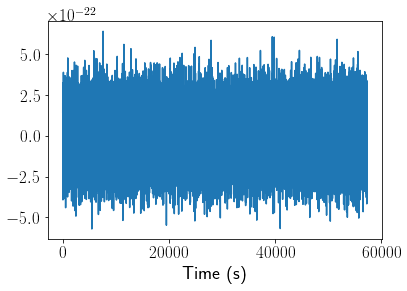

In [14]:
import pycbc.noise
import pycbc.psd
psd_noise = pycbc.psd.aLIGOZeroDetHighPower(len(psd), df, f_low)

noise_ = pycbc.noise.noise_from_psd(len(strain), strain.delta_t, psd_noise)
noise_ = resample_to_delta_t(highpass(noise_, f_low), dt)
noise_t = noise_.crop(2, 2)
noise = make_frequency_series(TimeSeries(np.array(noise_t), delta_t=dt))
np.save(noise_file,noise)

plt.plot(noise_t)
plt.xlabel('Time (s)')
plt.show()

In [15]:
SNR_threshold=12.

4.315182055162928
5.542374773539348
5.360549865793568
4.390915443279356
5.262990613909777
5.008913486362067
2.7993845276788165
3.0159374031873827
4.620999391404736
4.8759742371709835
5.296139453992565
3.5664502775418936
4.461496670254364
5.216661737154436
4.652738450152155
4.839718757387496
4.531273330722323
6.097486511169484
4.6067133694107945
5.300906550784914
2.5676757513967887
4.805113762057983
4.878221191840317
4.3948838788948486
9.472080270664303
3.948687886346865
4.2832480521833824
4.060990171966766
3.9142549185787097
3.331390400337301
4.549665688038697
4.431540214643063
8.98637139199448
4.9443974582444525
4.43192490687827
9.860403923615007
4.705675961951869
2.537728447827062
3.36379794396873
2.761074083195036
2.7481458095082547
6.936484424000785
3.390866498908922
6.20708128522419
4.652785562419809
4.3646259153249405
3.500484267600958
4.744420500489259
4.378798451675336
4.650895514044984
4.940367655300607
3.2435168319492447
2.7235097857268173
5.129898660177047
5.24541295028068
5

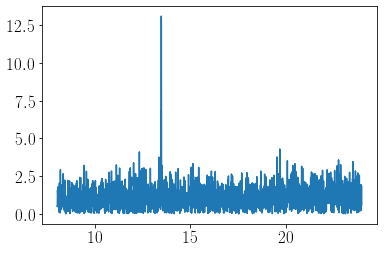

13.101649390710131
4.694352963214235
4.507033497906457
8.746718974127717
4.23346009568668
4.619844288533438
4.447002390317379
5.632020735081396
9.07523122057911
3.4788564516060196
4.538186678800848
4.729821052993393
5.127322979131861
2.2725231194030693
2.870920520948667
2.9169627772474875
4.548945738550054
5.294512296071235
2.5704260668804317
4.846914036940107
5.227693397192978
6.348899743018355
4.386190915526481
3.8244972754197595
4.937425934802954
2.664605118921589
2.6769953584962316
4.558915614238755


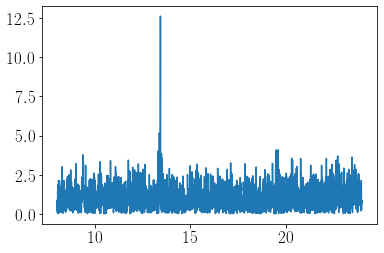

12.614558938556899
3.0613644312041606
2.552190262763599
5.349785610443854
4.507189435071631
4.270909120491119
2.69218649623979
8.667232616216523
3.3054277069244535
5.012966752270311
4.890110661146462
4.736585220626936
5.807372220929528
4.419849586621899
3.487324930948691
9.852040307604838
4.367749389928737
4.643432883874763
4.690603561098449
3.046096357298364
4.37350231980363
3.434716733570303
5.2370603252625925
4.344797407205596
4.3143974547600985
3.628061794062501
5.272245732467617
4.236183302393398
4.8332138763002686
4.504449960099454
4.712235061399115
4.629587898283705
2.8619168847040126
9.36352984266304
5.043174454154002
4.594913810060833
3.2582424179183844
5.36860731412718
4.263582540028765
4.426836189093178
4.848139626298216
4.680674744944122
4.552089420261422
4.362217777987564
2.8137861511560307
4.6203004650199135
3.2002490075407692
4.0347189603573925
4.814383548078876
4.9445684726526515
5.549998346816513
4.847365305571225
3.382489978631639
4.882161693974537
5.077381505335571
4

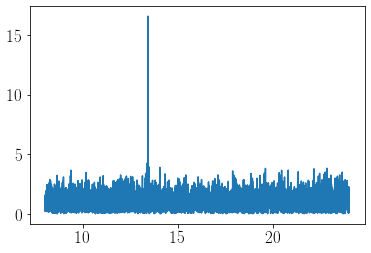

16.576928695451432
5.1957057305781005
4.697238600181619
5.0200347932891685
4.614768794054164
4.769079596455629
3.0151055050846054
4.499695371963973
5.244456013456867
4.81207298592113
2.489037973387411
2.999266030484463
3.006109879647778
4.31960668898633
4.8226125485913505
4.549876689941786
2.690304665922588
4.207317450050591
5.026352845629376
2.919307912871157
9.10603956335908
4.225358926620967
5.222451625474757
4.25493236923257
2.895236155970957
4.757561736583761
5.7193825064782935
2.769395422023405
4.9755658247028265
4.730651628945285
5.008437107175606
4.773078070947243
5.070297160443673
4.381526094925165
4.9356624605457435
4.914841048122693
4.636340169351452
5.771687307235095
5.017755896097199
4.338657542546674
3.793713632339916
5.350132256991366
3.0244948745636724
2.929617133714854
4.915519923392421
2.7230232588310477
4.891849192965296
4.371778964498339
4.953325949226704
2.295810123578855
3.005314230164664
7.074865496181523
4.694974934519863
2.808537576952014
4.347138197015096
3.02

In [16]:
from pycbc.filter import matched_filter

SNRs = []
signal_f = np.array(signal)

#for template,hp_f,hp in zip(templates,hps_f,hps):
#    template_f = np.array(make_frequency_series(TimeSeries(hp, delta_t=dt)))
for i,hp_f in enumerate(hps_f):
    #print(hp_f)
    snr_ = matched_filter(FrequencySeries(hp_f, delta_f=df), 
                                   FrequencySeries(signal_f, delta_f=df), 
                                   psd=FrequencySeries(psd_,delta_f=df))#, low_frequency_cutoff=bank['f_lower'][i])
    snr_ = snr_.crop(8, 4)
    snr = np.array(snr_)
    SNRs.append(np.max(np.abs(snr)))
    if SNRs[-1]>=SNR_threshold:
        plt.plot(snr_.sample_times, abs(snr_))
        plt.show()
    print(np.max(np.abs(snr)))
SNRs = np.array(SNRs)
print(SNRs[SNRs>SNR_threshold])

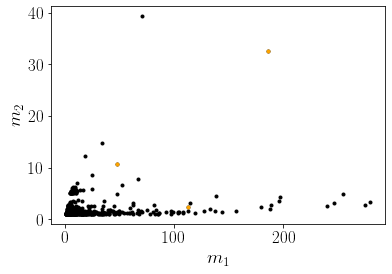

[186.17384  112.55197   48.223167] [32.53974    2.2795582 10.665815 ]


In [17]:
%matplotlib inline
plt.scatter(bank['mass1'],bank['mass2'],marker='.',color='black')
plt.scatter(bank['mass1'][SNRs>SNR_threshold],bank['mass2'][SNRs>SNR_threshold],marker='.',color='orange')

plt.xlabel(r'$m_{1}$')
plt.ylabel(r'$m_{2}$')
plt.show()
print(bank['mass1'][SNRs>SNR_threshold],bank['mass2'][SNRs>SNR_threshold])

In [18]:
from pycbc.filter import matched_filter

SNRs = []
signal_f = np.array(noise)

#for template,hp_f,hp in zip(templates,hps_f,hps):
#    template_f = np.array(make_frequency_series(TimeSeries(hp, delta_t=dt)))
for i,hp_f in enumerate(hps_f):
    #print(hp_f)
    snr_ = matched_filter(FrequencySeries(hp_f, delta_f=df), 
                                   FrequencySeries(signal_f, delta_f=df), 
                                   psd=FrequencySeries(psd_,delta_f=df))#, low_frequency_cutoff=bank['f_lower'][i])
    snr_ = snr_.crop(8, 4)
    snr = np.array(snr_)
    SNRs.append(np.max(np.abs(snr)))
    if SNRs[-1]>=SNR_threshold:
        plt.plot(snr_.sample_times, abs(snr_))
        plt.show()
    print(np.max(np.abs(snr)))
SNRs = np.array(SNRs)
print(SNRs[SNRs>SNR_threshold])

0.9007471476012618
1.6810402229762578
2.1260989644118857
0.8701194544363691
1.8207103005735212
1.7334589680475405
0.7827033629010991
0.7591628612796403
1.8105041848839134
1.592776773761897
2.037262474736623
0.8103242671494851
1.4616544897447776
0.8809509629989274
1.8557222568234912
1.7242772329078644
1.6201833605945768
1.9448174439649182
1.4662041664115193
2.007429092356447
0.4357196647761185
1.704203343594721
2.010516073586148
1.873480603617998
1.8775129530900112
1.4642914887266325
1.690376230961265
1.4824800791999737
0.9083303591445611
0.7990701619111312
1.779869299374435
0.828987123702401
1.6161627301756887
1.6618516809869093
0.929993130080997
1.5427708349659086
1.5838741460533217
0.5011142043675911
0.7997980716076472
0.6046116409248138
0.48340222511032593
1.5505505724344568
0.8822390602251241
1.5858672195967356
1.7349748997438599
1.7893200580707476
0.8189518063481702
1.8824542045941777
1.6955664187914556
1.8345757217454766
1.9742079320868244
0.769622787461347
0.4829561734493524
1.9

1.877755699792304
1.6222503986229204
0.7752630096602869
1.8592560630624932
2.0219832449895274
0.5121586359198692
1.1563505608380489
1.6089668415865022
1.8610750193450925
1.793828918516743
1.9369906910921766
1.7927168758974155
0.8683508758848647
1.6437101404806866
0.862373727257056
1.805233926438261
0.9160944661209549
0.764940857563084
0.8369250025628938
1.7517360572342648
0.7859070206076519
0.5960146885688371
1.7959332248137767
0.6141218172207059
1.9730410994563101
1.828195875865486
0.8798885696590584
0.43253813441910205
0.7628195075093842
1.6135663666193931
0.9663686419109414
0.5651212479886852
2.0152164932423484
0.7184512020758502
1.509335157864216
1.072178154790091
0.7500232501722183
1.3009965482961947
1.7205296784496402
0.9092707780724203
1.7653270136524712
1.674125795147158
0.6102451171430712
1.6583287197712235
1.7713314564440723
1.769798426748244
1.8880458165441107
1.8247051930802816
0.8600562285712677
0.7894237085453726
1.7036775216242128
1.7202054216405167
1.660623015785755
0.6

In [19]:
#%matplotlib inline

#plt.scatter(waveforms.table['mass1'],waveforms.table['mass2'],marker='.',color='black')
#plt.scatter(waveforms.table['mass1'][SNRs>SNR_threshold],waveforms.table['mass2'][SNRs>SNR_threshold],marker='.',color='orange')

#plt.xlabel(r'$m_{1}$')
#plt.ylabel(r'$m_{2}$')
#plt.show()

In [20]:
max_ind = np.argmax(SNRs)

print(bank['mass1'][max_ind],bank['mass2'][max_ind])
print(bank['spin1z'][max_ind],bank['spin2z'][max_ind])
print(bank['f_lower'][max_ind])

27.012365 2.5024934
0.9841782 0.94963366
27.1


In [21]:
print(SNRs)

[0.90074715 1.68104022 2.12609896 0.87011945 1.8207103  1.73345897
 0.78270336 0.75916286 1.81050418 1.59277677 2.03726247 0.81032427
 1.46165449 0.88095096 1.85572226 1.72427723 1.62018336 1.94481744
 1.46620417 2.00742909 0.43571966 1.70420334 2.01051607 1.8734806
 1.87751295 1.46429149 1.69037623 1.48248008 0.90833036 0.79907016
 1.7798693  0.82898712 1.61616273 1.66185168 0.92999313 1.54277083
 1.58387415 0.5011142  0.79979807 0.60461164 0.48340223 1.55055057
 0.88223906 1.58586722 1.7349749  1.78932006 0.81895181 1.8824542
 1.69556642 1.83457572 1.97420793 0.76962279 0.48295617 1.90770075
 1.67691277 1.68998617 0.78333415 1.50218019 0.44891116 0.6034204
 1.75557094 0.51189411 1.71412619 0.96468063 1.88112926 2.00120411
 0.4297876  1.90769219 1.36564959 1.86657834 0.52186935 0.66201746
 1.73245972 1.03753472 1.68489452 1.76078698 0.91191177 1.37431279
 0.86633556 0.94570532 0.83955288 1.82228673 1.8215563  0.90552747
 1.75238111 0.88609676 0.58113552 1.46558785 0.83340098 0.7897437

In [22]:
print(len(SNRs))

516
